## 1. Transformer & Attention

--------------------------------------
**_Disclaimer: I would like to spend some time describing the attention mechanism because for implementation of Vision Transformer I will use [Keras MultieadAttention layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). So what goes on there is worth understanding. If you want to jump into vision transformer implementation jump to section 2._**   


-------------------------------------


To understand Vision Transformer, first we need to focus on the basics of transformer and attention mechanism. For this part I will follow the paper **[Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)**. This paper itself is an excellent read and the description/concepts below are mostly taken from there and it will only help us to proceed further. 



 The idea of transformer is to use attention without recurrence (read RNN). So transformer is still a sequence to sequence (Seq2Seq) model and follows encoder-decoder structure. To quote from the paper--
 
>The encoder maps an input sequence of symbol representations $(x_1, \ldots, x_n)$ to a sequence
of continuous representations $z = (z_1, \ldots, z_n)$. Given $z$, the decoder then generates an output sequence $(y_1, \ldots, y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next. 


Let's see the Transformer structure introduced in the paper

![Transformer](https://drive.google.com/uc?id=1BXHTi4lUivqVv-T7VnTWgEdQ-2pBVUfY)


The encoder takes the input data (sentence/sequence), and produces an intermediate representation of the input. The decoder decodes this intermediate representation step by step and generates the output. The $Nx$ part in above picture are number of stacked layers, in orginal paper it's 6.  Once we understand the encoder part of the above structure we can move to vision transformer. Encoder layer contains 2 very important components, 

1. Multi-head self-attention block. 
2. Position wise, fully-connected feed forward network.   

Let's focus on the multi-head self attention part. The paper itself has a diagram of scaled dot-product attention and multi-head attention which consists of several attention layers running in parallel. 

![mutli-head](https://drive.google.com/uc?id=1_dXyDo1khaK4pmcfFzFyOZhDnSUL5Rux)

The 3 labels in the diagram Q, K, V denotes Query, Key and Value vectors. For now we think of this as part of information retrieval protocol when we search (query) and the search engine compares our query with a key and responds with a value (output).

In the orginal paper 3 different usages of multi-head attention were described. Let's quote directly from paper-

> 1. In "encoder-decoder attention" layers, the _queries_ come from the previous decoder layer, and the memory _keys_ and _values_ come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models. 
2. The encoder contains self-attention layers. In a self-attention layer all of the _keys_, _values_ and _queries_ come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder. 
3. Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.

For our purpose (to understand vision transformer), most important point is 2, i.e. self-attention in encoder part. Let's deep dive! 


## 1.1. Self-Attention

Let's consider an input sequence $(x_1, x_2, \ldots , x_m)$. Output of self-attention layer from this input sequence is a set of context vectors of same length $(C_1, C_2, \ldots , C_m)$ as input sequence. The picture below will help us

![S-attention1](https://drive.google.com/uc?id=1YNZcH34tH4LK4obSEyDyyDRobbD6tddV)

In the picture above we define the weights that will be trained as $W_q, W_k, W_v$ for _query_, _keys_ and _values_. How they are actually used? Let's see the picture below--

![S-attention2](https://drive.google.com/uc?id=1WHEc75C4TKpc4VBiwNPO1XqbWo9JvQt6)

It is important to note that same weight is applied for all $i$s. In the _Attention is All You Need_ paper, the dimensions of _query_ and _key_ are taken as $d_k$ and for _values_ it is assumed $d_v$. For example if we have  $x_i$s of dimension 5 i.e. [0 1 1 2 3] and _query_ has dimension 3 then $W_q$ will have dimension $5\times 3$. Same goes for _keys_ and _values_ and corresponding weights. So how these context vectors are calculated? Let's see below--

![S-attention3](https://drive.google.com/uc?id=1ca3Eu4LMAbKqg6IxQDEfmTJVrsEdCxHG)

The figure above describes the dot-product attention which was introduced in the paper. Important point is for calculating $\alpha _j$ (see figure above) at position $q_j$ (same as $x_j$) we use information from $q_j$ only but all other _Keys_ ($k_j$s). We are left with the final step to calculate the output of attention layer and that is to use the _values_ as below--

![S-attention4](https://drive.google.com/uc?id=14AYcINN08Af983BcyGBeOT7eaOM278Lx)

Here we see how we take the product of $v_i$ with $\alpha \equiv Softmax \left(\frac{QK^T}{\sqrt{d_k}}\right)$.  

To calculate context vector at position $i$ we need values from all the inputs. Finally, how do we think about the scaling factor $\left(\frac{1}{\sqrt{d_k}} \right)$ in the scaled dot attention function ?

Usually we will initialize our layers with the intention of having equal variance throughout the model. But when we perform the dot product over these two vectors $(Q, K)$ with a variance $\sigma ^2$, this will result in a scaler having $d_k$ times higher variance. Remember also that $d_k$ is the dimension of both $Q, K$, while $V$ has dimension $d_v$. 

$$q_i \sim N(0, \sigma ^2), \, k_i \sim N(0, \sigma ^2), \rightarrow \text{Var} \left(\sum \limits_{i=1}^{d_k} q_i \cdot k_i \right) = \sigma ^2 \cdot d_k $$ 

If we do not scale down the variance back to $\sigma ^2$, the softmax over the logits would have saturated to $1$ for one random element and $0$ for all others. The gradients through the softmax will be close to zero so that we can’t learn the parameters appropriately. 

At this point we can at-least appreciate the scaled dot product attention diagram (figure: 2) that was introduced in the paper. 


----------------------------------------

## 1.2. Multi-Head Attention (Self)

It's a very simple extension of single head self-attention. 

1. In Multi-head self-attention we have $h$ single head self-attentions (layers). 

2. In a single head self attention trainable parameters are weights $W_q, W_k, W_v$

3. The $h$ single head self-attention layers do not share parameters. So total $3h$ parameters. 

4. Each single head self-attention outputs a context vector. 

5. These context vectors are concatenated. 

6. If a single head attention outputs a dimensional vector i.e. each $C_i$’s are $d \times 1$, then multi-head outputs are $hd \times 1$ dimensional vector, given $h$ layers of single head self-attention layers.      

To quote from paper on the importance of multi-head attention--

> Multi-head attention allows the model to jointly attend to information from different representation subspaces at different position. With a single attention head, averaging inhibits this.


## 2. Vision Transformer (Step by Step)

Implement vision transformer on [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

For this implementation we will use concepts and methods described in the original [ViT paper](https://arxiv.org/abs/2010.11929) by Dosovitskiy et.al. Here it is mentioned that ViTs are data hungry architectures and the performance of ViTs even in relatively large dataset like ImageNet without strong regularization yields accuracies few percentages below ResNet. But the scenario changes when Transformers are trained on larget datasets (14M-300M images). The original implementation is available in [google github](https://github.com/google-research/vision_transformer/blob/main/vit_jax/models.py) and a very similar version in [tensorflow models](https://github.com/tensorflow/models/blob/master/official/vision/beta/projects/vit/modeling/vit.py). We will discuss each step in detail but first let's get started with loading data. 

**ViT TLDR:** 

1. Take an image $(256 \times 256 \times 3)$.
2. Turn images into smaller patches $\left(\text{ex:}\,  16 \times 16 \times 3 \, ,\,  \, \text{total} \, 256\,  \left(N=\frac{256 \times 256}{16^2} \right)  \text{patches} \right)$. 
3. These patches then were linearly embedded. We can think of these now as tokens. 
4. Use them as input for Transformer Encoder (contains multi-head self attention). 
5. Perform the classification. 
6. Bye Bye Convolution. 


 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print ('check shapes: ', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# train_im, test_im = x_train/255.0 , x_test/255.0

train_lab_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True) # stratify is unncessary 

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

print ('train im and label types: ', type(train_im), type(train_lab))

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices((x_test, test_lab_categorical))

print ('check types; ', type(training_data), type(validation_data))


autotune = tf.data.AUTOTUNE 

train_data_batches = training_data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)
test_data_batches = test_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)

170508288/170498071 [==============================] - 11s 0us/step
check shapes:  (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)
train im and label types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
check types;  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


## 2.1. Patch Generation 

Let's discuss what's described in paper. 

Consider an image, $x \in \mathbb{R}^{H\times W \times C}$, and turn it into a sequence of patches $x_p \in \mathbb{R}^{N\times P \times P \times C}$, where $(H, W )$ is the height and Width of the original image, $C$ is the number of channels, $(P, P )$ is the resolution of each image patch, and $N = HW/P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.   

Check the tensorflow example page about [custom layer](https://www.tensorflow.org/tutorials/customization/custom_layers) for examples, we follow the example given there. 

The best way to implement your own layer is extending the tf.keras.Layer class and implementing:

1. `__init__` , where you can do all input-independent initialization.
2.     `build`, where you know the shapes of the input tensors and can do the rest of the initialization, *this part isn't necessary*.
3. `call`, where you do the forward computation.


For the patch generation, I will follow what was done in [original code](https://github.com/google-research/vision_transformer/blob/main/vit_jax/models.py) but I will discuss another method too which was discussed in [Keras Blog](https://keras.io/examples/vision/image_classification_with_vision_transformer/).  

1. We can use [`tf.image.extract_patches`](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches). To quote from the page

>This op collects patches from the input image, as if applying a convolution. All extracted patches are stacked in the depth (last) dimension of the output.

Using this we can literally create patches from the images, the patches were then flattened. Then use a dense layer with learnable weights to project it with a hidden dimension (this will be more clear soon). In addition, it adds a learnable position embedding to the projected vector.  Final shape of the output will be `(batch_size, num_patches, hidden_dim)`. An example using an image tensor till patch creation is shown below. 

2. In the original code instead of creating patches and then adding learnable weights via Dense layer to project it on a certain dimension, we directly use a convolutional layer (with learnable weights) with number of filters equal to this hidden dimension. So the shape here is already `(batch_size, num_patches, hidden_dim)` and then a learnable position embedding layer of same shape was added to the input. 

We will discuss both methods. But before that what's this hidden dimension ? This is the dimension of Query and Key (previously we wrote it as $d_k$) and we will use this in the encoder block when we need the [`MultiHeadAttention` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). So this projection is done in such a way that we can directly feed the embedded patches (flattened) to the transformer. Great ! Slowly things are building up. 


### 2.1.1 Patch Generation to Embed (Keras Blog)

In [ ]:
class generate_patch(layers.Layer):
  def __init__(self, patch_size):
    super(generate_patch, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images, 
                                       sizes=[1, self.patch_size, self.patch_size, 1], 
                                       strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims]) #here shape is (batch_size, num_patches, patch_h*patch_w*c) 
    return patches

check shapes:  (1, 32, 32, 3)
patch per image and patches shape:  64 
 (1, 64, 48)


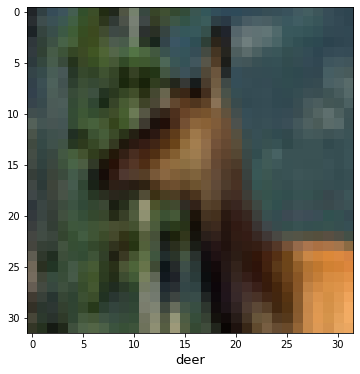

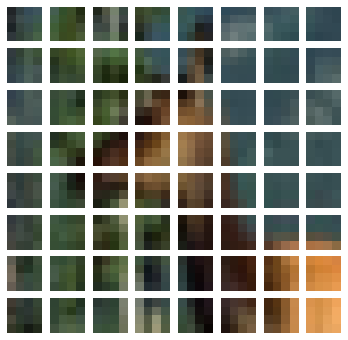

In [ ]:
from itertools import islice, count

train_iter_7im, train_iter_7label = next(islice(training_data, 7, None)) # access the 7th element from the iterator



train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy()

print('check shapes: ', train_iter_7im.shape) 

patch_size=4 
######################
# num patches (W * H) /P^2 where W, H are from original image, P is patch dim. 
# Original image (H * W * C), patch N * P*P *C, N num patches
######################
generate_patch_layer = generate_patch(patch_size=patch_size)
patches = generate_patch_layer(train_iter_7im)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)



def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')    

        


render_image_and_patches(train_iter_7im, patches)

In [ ]:
### Positonal Encoding Layer

class PatchEncode_Embed(layers.Layer):
  '''
  2 steps happen here
  1. flatten the patches 
  2. Map to dim D; patch embeddings  
  '''
  def __init__(self, num_patches, projection_dim):
    super(PatchEncode_Embed, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)# activation = linear
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim)
    
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [ ]:
patch_encoder = PatchEncode_Embed(64, 64)(patches)
print (tf.shape(patch_encoder))

tf.Tensor([ 1 64 64], shape=(3,), dtype=int32)


In [ ]:
### compare with conv layer (tf extract image)
# train_iter_7im = tf.cast(train_iter_7im, dtype=tf.float32)
# x_conv = layers.Conv2D(48, patch_size, patch_size, padding='valid')(train_iter_7im)

# print (x_conv.shape)


# patches = tf.image.extract_patches(images=train_iter_7im, 
#                                        sizes=[1, patch_size, patch_size, 1], 
#                                        strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")

# print (patches.shape)

# patches = tf.reshape(patches, [1, -1, patches.shape[-1] ] )
# print (patches.shape)

### 2.2. Patches and Embedding (Original Implementation)

How the original implementation works were described in section 2.1 (Patch Generation), point 2. 

Here I wrote 2 different layers, 

1. `generate_patch_conv`: Directly compare with the extract image part we checked before, to understand conv layer is very similar to `extract image` method except of course `Conv2D` layer is leranable. 

1. `generate_patch_conv_orgPaper`: What was done by the google researchers. Number of filters in the `Conv2D` layer matches the hidden dimension i.e. query/key dimension in multi-head attention layer. 

In [ ]:
class generate_patch_conv(layers.Layer):
  '''
  this is an example to generate conv patches comparable with the image patches
  generated using tf extract image patches. This wasn't the original implementation, specially 
  the number of filters in the conv layer has nothing to do with patch size. It must be same as
  hidden dim (query/key dim) in relation to multi-head attention layer.       
  '''
  def __init__(self, patch_size):
    super(generate_patch_conv, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = layers.Conv2D(self.patch_size*self.patch_size*3, self.patch_size, self.patch_size, padding='valid')(images)

    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches  

class generate_patch_conv_orgPaper(layers.Layer):
  '''
  original implementation, 
  hidden size = query/key dim in multi head attention layer later. 
  '''
  def __init__(self, patch_size, hidden_size):
    super(generate_patch_conv_orgPaper, self).__init__()
    self.patch_size = patch_size
    self.hidden_size = hidden_size

  def call(self, images):
    patches = layers.Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding='valid', name='Embedding')(images) 
    # kernels and strides = patch size
    # the weights of the convolutional layer will be learned. 
    rows_axis, cols_axis = (1, 2) # channels last images
    #if channels_last:
      #rows_axis, cols_axis = (2, 3) # for channels last
      # x = tf.transpose(patches, perm=[0, 2, 3, 1]) # do this for channels_first
    seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
    return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
  patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
  row_axis, col_axis = (1, 2) # channels last images
  seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
  x = tf.reshape(patches, [-1, seq_len, hidden_size])
  return x




train_iter_7im = tf.cast(train_iter_7im, dtype=tf.float16)
generate_patch_conv_layer = generate_patch_conv(patch_size=patch_size)
patches_conv = generate_patch_conv_layer(train_iter_7im)


print ('patch per image and patches shape: ', patches_conv.shape[1], '\n', patches_conv.shape)    

generate_patch_conv_orgPaper_layer = generate_patch_conv_orgPaper(patch_size=patch_size, hidden_size=64)
patches_conv_org = generate_patch_conv_orgPaper_layer(train_iter_7im)

hidden_size=64
patches_conv_org_f = generate_patch_conv_orgPaper_f(patch_size, hidden_size, train_iter_7im)

print ('patch per image and patches shape: ', patches_conv_org.shape[1], '\n', patches_conv_org.shape)
print ('patch per image and patches shape: ', patches_conv_org_f.shape[1], '\n', patches_conv_org_f.shape)

patch per image and patches shape:  64 
 (1, 64, 48)
patch per image and patches shape:  64 
 (1, 64, 64)
patch per image and patches shape:  64 
 (1, 64, 64)


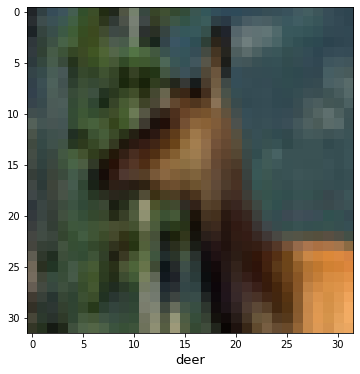

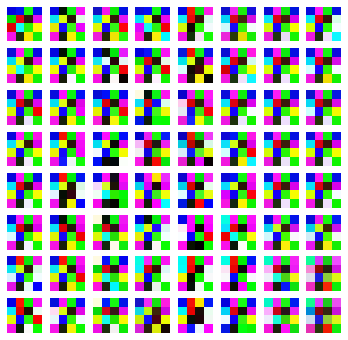

In [ ]:
def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')

render_image_and_patches(train_iter_7im, patches_conv)        

In [ ]:
# x_conv = layers.Conv2D(64, patch_size, patch_size, padding='valid')(train_iter_7im)

# print(x_conv.shape)

# #x_conv = tf.transpose(x_conv, perm=[0, 2, 3, 1])

# #print(x_conv.shape)

# seq_len = (train_iter_7im.shape[1] // patch_size) * (train_iter_7im.shape[2] // patch_size)

# x = tf.reshape(x_conv, [-1, seq_len, 64])

# print(x.shape)

In [ ]:
### Positonal Encoding Layer

class AddPositionEmbs(layers.Layer):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, posemb_init=None, **kwargs):
    super().__init__(**kwargs)
    self.posemb_init = posemb_init
    #posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input') # used in original code

  def build(self, inputs_shape):
    pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
    self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

  def call(self, inputs, inputs_positions=None):
    # inputs.shape is (batch_size, seq_len, emb_dim).
    pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

    return inputs + pos_embedding


pos_embed_layer = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))
embedded_inp = pos_embed_layer(patches_conv_org)

print ('embedded input shape: ', embedded_inp.shape)

embedded input shape:  (1, 64, 64)


Let's discuss some important point related to the encoding of the patches. To quote from the paper--  

> The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to
the output of this projection as the patch embeddings. 

$$z_0 = \left[x_{\text{class}}; x_p^1\cdot E; x_p^2\cdot E; \ldots x_p^N\cdot E \right] + E_{\text{pos}}; \, \, E \in \mathbb{R}^{(P^2 \times C)\times D} , E_{\text{pos}} \in \mathbb{R}^{(N +1)\times D} \, \ldots (1)$$

The `cls` token is similar to that of [BERT's](https://arxiv.org/abs/1810.04805) class token. 

How a ViT architecture is different from a CNN and Positional Embedding--

Once we flatten the images to patches, we lose the structures of the input and the positional embedding helps allow the model to learn about the structure of the input image. These positional embeddings are learnable and highlights how much about image structure the model can learn on its own. In CNN if we consider kernels, it's about learning 2-D neighborhood structure; but in transformers apart from the MLP layer this local 2-D structure isn't used and the positional embeddings at the initialization time carry no information about the 2-D position of the patches and all spatial relations between the patches are learned from scratch.       


Afer the embedding part, we feed them into the multi-head self attention and multi-layer perceptron layers (in that order), and that essentially is the transforner block in VIT. A visual representation is take from the [Google blog](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html) is shown below.   

![VITransformer_Gif](https://drive.google.com/uc?id=1BUBJ7pSJxNVIrhkpex6owgrjixXiwpAl)


The visual representation of specifically  the Transformer encoder block is shown below and this will help us to implement it better. 

![Transf_Enc](https://drive.google.com/uc?id=1uKWAIAHjwbP_jhSj_AR6UC7LdawDizOn)



## 2.3. Transformer Encoder with Multi-Head Self Attention 

Here we will implement the Transformer Encoder block shown above. 

Few Points ---

1. We still need to define the Multilayer Perceptron (MLP) part. 
2. What is `Norm` ? How to implement? 
3. We can clearly see 2 residual connections, which will also be added. 


**_MLP:_** . To quote from the paper: 

> The MLP contains two layers with a GELU non-linearity. 

Check out the Gaussian Error Linear Units [(GELU) paper](https://arxiv.org/abs/1606.08415) and I skip the discussion here. This activation is available within `tf.nn`. The MLP sizes are given in paper and for this simplified implementation we will use much smaller (number of units) `Dense` layers. Since the encoder block repeats, we have to be careful about the number of units in the `Dense` layer because the output dimension have to be compatible with the input for the next `MultiHeadAttention` layer.     

**_Norm:_** The Norm in the figure refers to [`LayerNormalization` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization). An excellent visual representation is available in the original [Group Normalization paper](https://arxiv.org/abs/1803.08494). In short, if we consider an input tensor with shape (N, C, H, W), It computes mean and variance $(\mu_i, \sigma _i)$ along the (C, H, W) axes. This ensures that computation for an input feature is entirely independent of other input features in a batch.  


With these info we are ready to move!




In [ ]:
# class mlp_block(layers.Layer):
#   def __init__(self, mlp_dim):
#     super(mlp_block, self).__init__()
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.Dense(units=self.mlp_dim, activation=tf.nn.gelu)(inputs)
#     x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
#     x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
#     x = layers.Dropout(rate=0.1)(x)
#     return x


def mlp_block_f(mlp_dim, inputs):
  x = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
  x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
  x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
  x = layers.Dropout(rate=0.1)(x)
  return x

# class Encoder1Dblock(layers.Layer):
#   def __init__(self, num_heads, mlp_dim):
#     super(Encoder1Dblock, self).__init__()
#     self.num_heads = num_heads # number of heads in multi-head block
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.LayerNormalization(dtype=self.dtype)(inputs)
#     x = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
#     x = layers.Add()([x, inputs]) # 1st residual part 
    
    # #### mlp block 
    # y = layers.LayerNormalization(dtype=self.dtype)(x)
    # y = mlp_block(mlp_dim=self.mlp_dim)(y)
    # y_1 = layers.Add()([y, x]) #2nd residual part 
    # return y_1


def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
  x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
  x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
  x = layers.Add()([x, inputs]) # 1st residual part 
  
  y = layers.LayerNormalization(dtype=x.dtype)(x)
  y = mlp_block_f(mlp_dim, y)
  y_1 = layers.Add()([y, x]) #2nd residual part 
  return y_1


#########################################
# test with the embeddings as input
#########################################
# Encoder1Dblock_layer = Encoder1Dblock(num_heads=4, mlp_dim=32)
# Encoder1Dblock_layer_out = Encoder1Dblock_layer(embedded_inp)
Encoder1Dblock_layer_out_f = Encoder1Dblock_f(4, 32, embedded_inp)

# print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out.shape)
print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out_f.shape)

output shape of Encoder block when inputs are the embeddings:  (1, 64, 64)


One final point, before combining all these for building the complete ViT, is the usage of `cls` token in the classfication part. This `cls` token is used as image representation and the output of this token is then transformed into a class prediction via a small multi-layer perceptron (MLP) with $\textrm{tanh}$ as non-linearity in the single hidden layer. 

But this `cls` token isn't necessary. To quote from the ViT paper

>This design is inherited from the Transformer model for text, and we use it throughout the main paper. An initial attempt at using only image-patch embeddings, global average-pooling (GAP) them, followed by a linear classifier—just like ResNet’s final feature map—performed very poorly.
However, we found that this is neither due to the extra token, nor to the GAP operation. Instead, the difference in performance is fully explained by the requirement for a different learning-rate. 

Due to this I will omit using the `cls` token and simply perform the Global Average Pooling (GAP) on the output of the transformer block which will be used as representation of the image. Finally we do the classification using an MLP and categorical cross entropy loss. 

We will add augmentation as layers and follow the generic `tf.data` pipeline which I've discussed in detail [here](https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435). 


--------------------------------------------------

## 3. Build ViT (Model and Model Summary)

In [ ]:
# explicitly check the implementation with 2 transformer encoder blocks

# def build_ViT_Param():
#   inputs = layers.Input(shape=train_im.shape[1:])
#   # rescaling (normalizing pixel val between 0 and 1)
#   rescale = rescale_layer(inputs)
#   # augmentation 
#   augmented = data_augmentation(rescale)
#   # generate patches with conv layer
#   patches = generate_patch_conv_orgPaper(patch_size=patch_size, hidden_size=hidden_size)(augmented)
#   embeddings = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))(patches)
#   embeddings = layers.Dropout(rate=0.4)(embeddings)

#   ######################################
#   # ready for the transformer blocks
#   # block 1
#   ######################################

#   ###############################
#   # attention block 1
#   ##############################

#   x_1 = layers.LayerNormalization(dtype=embeddings.dtype)(embeddings)
#   x_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x_1, x_1) # self attention multi-head, dropout_rate is from original implementation
#   x_1 = layers.Add()([x_1, embeddings]) # 1st residual part 
    
#   #### mlp block 1
#   y_1 = layers.LayerNormalization(dtype=x_1.dtype)(x_1)
#   x_2 = layers.Dense(units=mlp_dim, activation='relu')(y_1)
#   x_2 = layers.Dropout(rate=0.1)(x_2) # dropout rate is from original paper,
#   x_2 = layers.Dense(units=y_1.shape[-1], activation=tf.nn.gelu)(x_2)
#   x_2 = layers.Dropout(rate=0.1)(x_2)
#   y_2 = layers.Add()([x_1, x_2]) #2nd residual part

#   # ######################################
#   # # ready for the transformer blocks
#   # # block 2
#   # ######################################

#   # ###############################
#   # # attention block 2
#   # ##############################

#   x_3 = layers.LayerNormalization(dtype=y_2.dtype)(y_2)
#   x_3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x_3, x_3) # self attention multi-head, dropout_rate is from original implementation
#   x_3 = layers.Add()([x_3, y_2]) # 1st residual part 
    
#   # #### mlp block 2
#   y_3 = layers.LayerNormalization(dtype=x_2.dtype)(x_3)
#   x_4 = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(y_3)
#   x_4 = layers.Dropout(rate=0.1)(x_4) # dropout rate is from original paper,
#   x_4 = layers.Dense(units=y_3.shape[-1], activation=tf.nn.gelu)(x_4)
#   x_4 = layers.Dropout(rate=0.1)(x_4)
#   y_4 = layers.Add()([x_3, x_4]) #2nd residual part

#   encoder_out = layers.LayerNormalization()(y_4)  

#   # #####################################
#   # #  final part (mlp to classification)
#   # #####################################
#   # #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
#   im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

#   logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

#   final_model = tf.keras.Model(inputs = inputs, outputs = logits)

#   return final_model


# vit_model_params = build_ViT_Param()
# vit_model_params.summary()

In [ ]:
### augment train but not test 

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])


train_ds = (training_data.shuffle(40000).batch(128).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=autotune).prefetch(autotune))
valid_ds = (validation_data.shuffle(10000).batch(32).prefetch(autotune))


In [ ]:
# class Encoder(layers.Layer):
#   def __init__(self, num_layers, mlp_dim, num_heads):
#     super(Encoder, self).__init__()
#     self.num_layers = num_layers # number of times encoder repeats
#     self.mlp_dim = mlp_dim
#     self.num_heads = num_heads

#   def call(self, inputs):
#     x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
#     x = layers.Dropout(rate=0.2)(x)
#     for _ in range(self.num_layers):
#       x = Encoder1Dblock(mlp_dim=self.mlp_dim, num_heads=self.num_heads)(x)

#     encoded = layers.LayerNormalization(name='encoder_norm')(x)
#     return encoded


def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
  x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
  x = layers.Dropout(rate=0.2)(x)
  for _ in range(num_layers):
    x = Encoder1Dblock_f(num_heads, mlp_dim, x)

  encoded = layers.LayerNormalization(name='encoder_norm')(x)
  return encoded




######################################
# hyperparameter section 
###################################### 
transformer_layers = 6
patch_size = 4
hidden_size = 64
num_heads = 4
mlp_dim = 128

######################################




def build_ViT():
  inputs = layers.Input(shape=train_im.shape[1:])
  # rescaling (normalizing pixel val between 0 and 1)
  rescale = rescale_layer(inputs)
  # augmentation 
  # augmented = data_augmentation(rescale)
  # generate patches with conv layer
  patches = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale)

  ######################################
  # ready for the transformer blocks
  ######################################
  encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches)  

  #####################################
  #  final part (mlp to classification)
  #####################################
  #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
  im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

  logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

  final_model = tf.keras.Model(inputs = inputs, outputs = logits)
  return final_model



ViT_model = build_ViT()
ViT_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 64)     3136        ['sequential[0][0]']             
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 64, 64)       0           ['conv2d_2[0][0]']               
                                                                                              

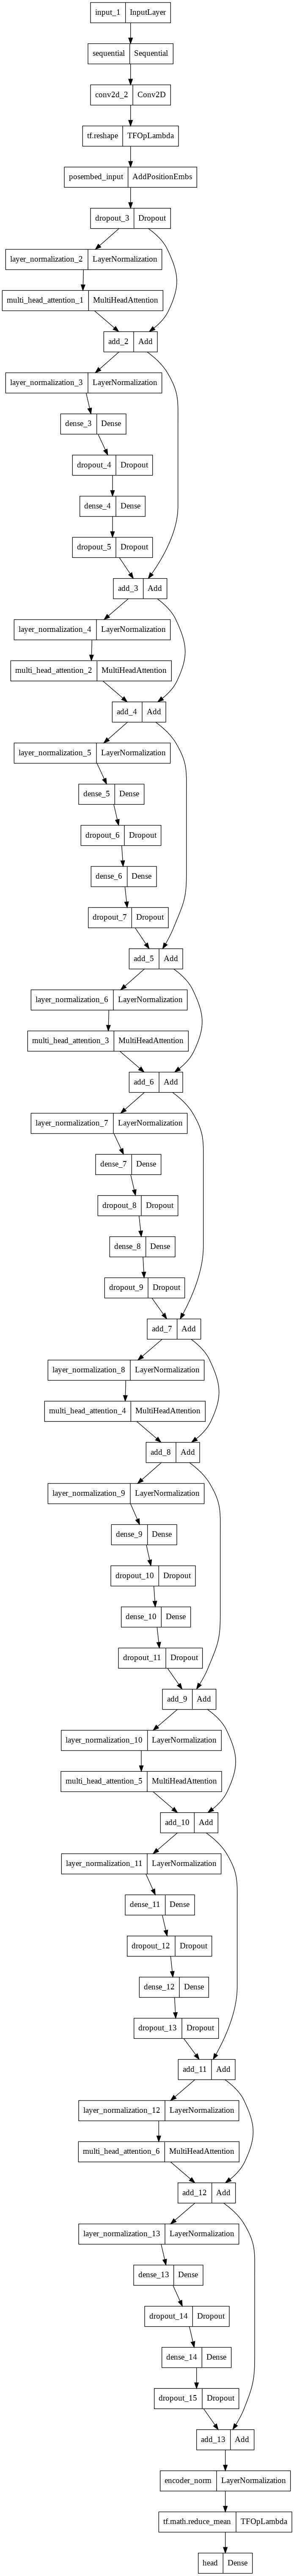

In [ ]:
tf.keras.utils.plot_model(ViT_model, rankdir='TB')

## 3.1. Model Compile 

In [ ]:
### model 

ViT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5 acc')]) 
#tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")],) 
# from logits = True, because Dense layer has linear activation


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5, verbose=1)


ViT_Train = ViT_model.fit(train_ds, 
                        epochs = 120, 
                        validation_data=valid_ds, callbacks=[reduce_lr])

Epoch 1/120
313/313 [==============================] - 60s 166ms/step - loss: 2.2448 - accuracy: 0.1388 - top5 acc: 0.5809 - val_loss: 2.0614 - val_accuracy: 0.2099 - val_top5 acc: 0.7447 - lr: 0.0020
Epoch 2/120
313/313 [==============================] - 50s 160ms/step - loss: 2.0572 - accuracy: 0.2244 - top5 acc: 0.7512 - val_loss: 1.9854 - val_accuracy: 0.2433 - val_top5 acc: 0.7868 - lr: 0.0020
Epoch 3/120
313/313 [==============================] - 50s 159ms/step - loss: 1.9927 - accuracy: 0.2484 - top5 acc: 0.7872 - val_loss: 1.9254 - val_accuracy: 0.2741 - val_top5 acc: 0.8183 - lr: 0.0020
Epoch 4/120
313/313 [==============================] - 50s 160ms/step - loss: 1.9643 - accuracy: 0.2614 - top5 acc: 0.7985 - val_loss: 1.9318 - val_accuracy: 0.2722 - val_top5 acc: 0.8077 - lr: 0.0020
Epoch 5/120
313/313 [==============================] - 50s 160ms/step - loss: 1.9348 - accuracy: 0.2753 - top5 acc: 0.8109 - val_loss: 1.8998 - val_accuracy: 0.2928 - val_top5 acc: 0.8171 - lr: 0.

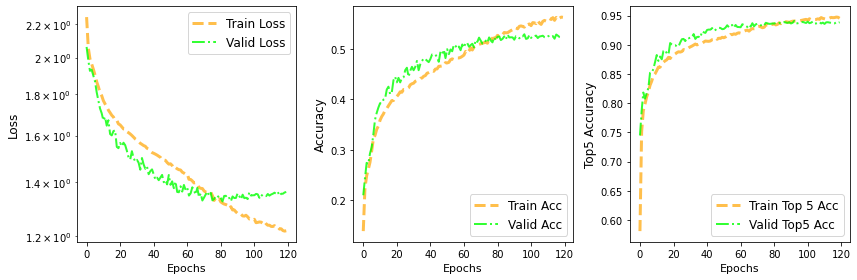

In [ ]:
### Plot train and validation curves
loss = ViT_Train.history['loss']
v_loss = ViT_Train.history['val_loss']

acc = ViT_Train.history['accuracy'] 
v_acc = ViT_Train.history['val_accuracy']

top5_acc = ViT_Train.history['top5 acc']
val_top5_acc = ViT_Train.history['val_top5 acc']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Top5 Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(y_test, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(y_test,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    # fig.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/heatmap.png', dpi=250)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.53      0.63      0.58      1000
  automobile       0.50      0.69      0.58      1000
        bird       0.52      0.36      0.42      1000
         cat       0.43      0.45      0.44      1000
        deer       0.59      0.40      0.48      1000
         dog       0.41      0.46      0.44      1000
        frog       0.54      0.69      0.61      1000
       horse       0.56      0.50      0.53      1000
        ship       0.67      0.60      0.63      1000
       truck       0.58      0.49      0.54      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000



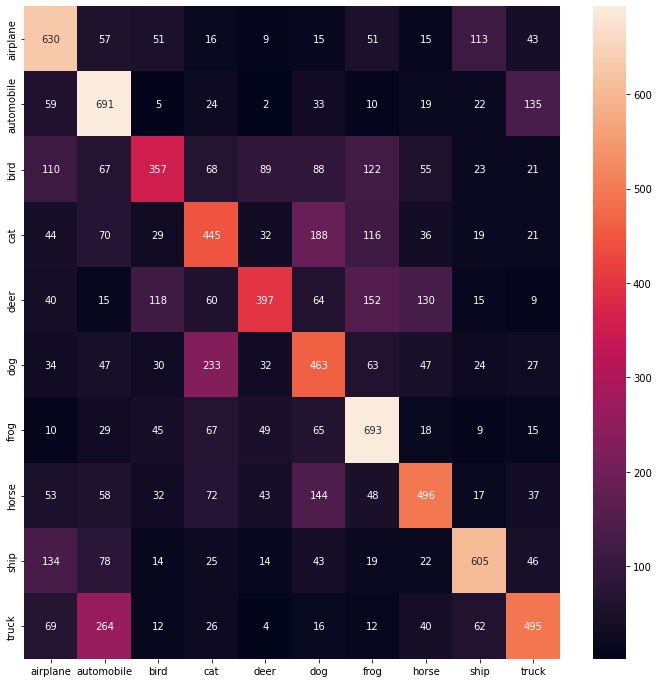

In [ ]:
pred_class_resnet50 = ViT_model.predict(x_test)

conf_matrix(pred_class_resnet50)